# L4 data set

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io

import glmnet_python
from glmnet import glmnet

import sparseRRR

# This file is from https://github.com/berenslab/rna-seq-tsne
import sys; sys.path.append('../rna-seq-tsne/')
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

In [6]:
# Load L4 data

data = pd.read_csv("../../BICCN patch-seq data/L4/rnaseq/counts.csv", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('../../BICCN patch-seq data/L4/Layer 4 cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

for h in cells:
    if '_'.join(h.split('_')[:3]) not in names2regions:
        print('NO META INFO: ' + h)
        
regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('../layer4/ephys/data/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

l4 = {'counts': counts, 'cells': cells, 'genes': genes, 
      'regions': regions, 'layers': layers, 'ephys': ephys,
      'ephysNames': ephysNames}

print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 118
Number of genes: 26514

['ADP (mV)' 'AHP (mV)' 'AI' 'AP amplitude (mV)' 'AP threshold (mV)'
 'AP width (ms)' 'Max number of spikes' 'Input R (MOhm)' 'Vm (mV)'
 'Latency (ms)' 'Rheobase (pA)' 'Sag ratio' 'Tau (ms)']
13


In [12]:
pickle.dump(l4, open('l4data.pickle', 'wb'))

In [2]:
l4 = pickle.load(open('l4data.pickle', 'rb'))

102
Chosen offset: 7.08


../rna-seq-tsne/rnaseqTools.py:46: RuntimeWarning: divide by zero encountered in log2
  meanExpr[detected] = np.nanmean(np.where(data[:,detected]>threshold, np.log2(data[:,detected]), np.nan), axis=0)


<IPython.core.display.Javascript object>


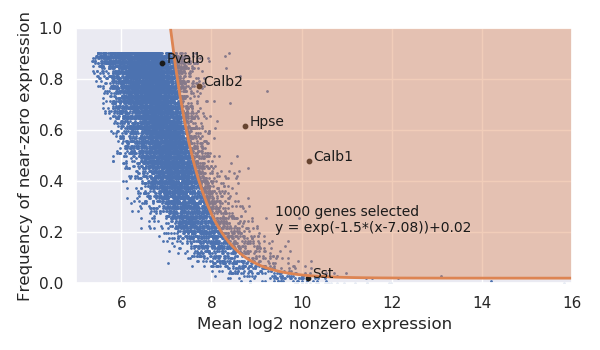

Shape of X: (102, 1000) 
Shape of Y: (102, 13)


In [3]:
# cells to exclude based on RNA (either low quality or mapps to PV/excitatory
exclude = ['20180605_sample_12_L4_S109', '20180626_sample_11_L4_S129',
           '20180703_sample_6_L4_S157', '20180919_sample_21_L4_S136',
           '20180605_sample_17_L4_S114', '20180626_sample_7_L4_S125',
           '20180627_sample_1_L4_S137', '20180703_sample_4_L4_S154']

selection = ~np.isin(l4['cells'], exclude) & ~np.isnan(np.sum(l4['ephys'],axis=1))
print(np.sum(selection))

genesForRRR = rnaseqTools.geneSelection(l4['counts'][selection,:], n=1000, threshold=32, decay=1.5, 
                                     markers=['Sst', 'Pvalb', 'Hpse', 'Calb2', 'Calb1', 'Mme', 'Tac1', 'Tac2'],
                                     genes=l4['genes'])

X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

1.......... Time: 0.0h  0m 47s


<IPython.core.display.Javascript object>


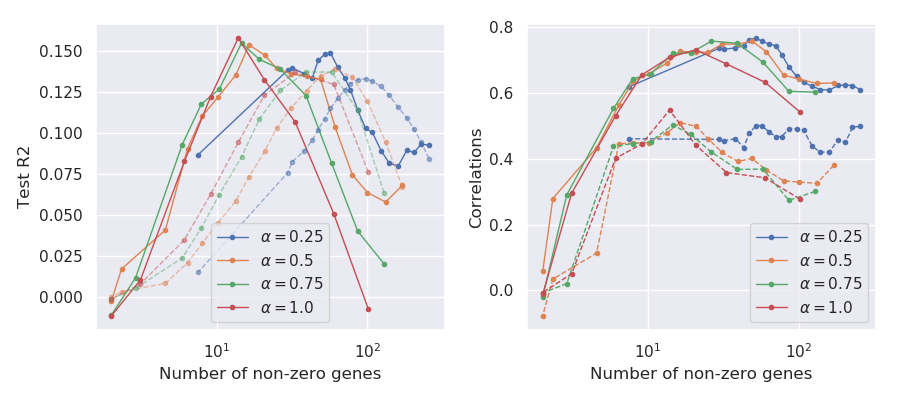

In [15]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])
alphas = np.array([.25, .5, .75, 1])

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=2, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)

<IPython.core.display.Javascript object>


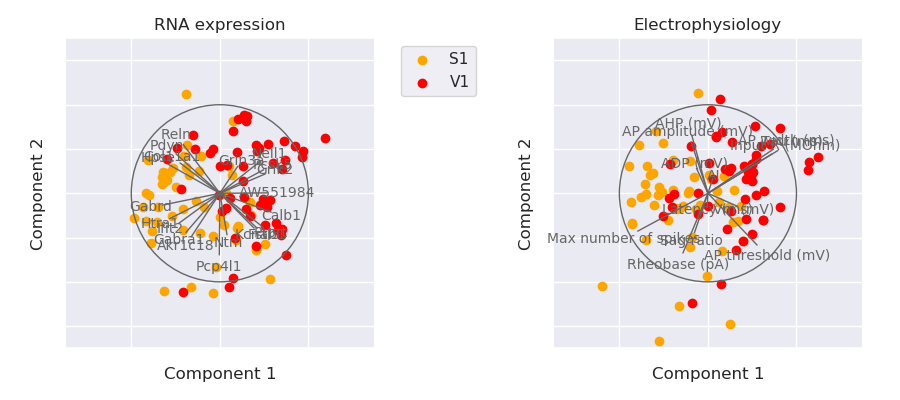

In [4]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5)